In [1]:
import gmsh
import numpy as np
from importlib.machinery import SourceFileLoader

el metodo initialize 'abre' el programa.

In [2]:
gmsh.initialize()

Info    : Increasing process stack size (8192 kB < 16 MB)


'armamos' el modelo que queremos modificar:

In [3]:
modelname = 'chapa_agujero'

In [4]:
gmsh.model.add(modelname)

In [5]:
lc = 2
R = 1   # radio del agujero
Long = 10

Definimos las coordenadas de los puntos

In [6]:
P  = [
     gmsh.model.geo.addPoint(0, 0, 0, lc/10),
     gmsh.model.geo.addPoint(R, 0, 0, lc/5),
     gmsh.model.geo.addPoint(Long, 0, 0, lc) ,
     gmsh.model.geo.addPoint(Long, Long/2, 0, lc) ,
     gmsh.model.geo.addPoint(0, Long/2, 0, lc) ,
     gmsh.model.geo.addPoint(0, R, 0, lc/5)
]

Luego definimos las lineas

In [7]:
L = [ 
 gmsh.model.geo.addLine(P[1],P[2]),
 gmsh.model.geo.addLine(P[2],P[3]),
 gmsh.model.geo.addLine(P[3],P[4]),
 gmsh.model.geo.addLine(P[4],P[5]),
 gmsh.model.geo.addCircleArc(P[5],P[0],P[1])
]

Las curvas nos van a servir para definir los bordes de nuestro modelo.

In [8]:
C1 = gmsh.model.geo.addCurveLoop(L)

Y las superficies:

In [9]:
S1 = gmsh.model.geo.addPlaneSurface([C1])

le avisamos que ya estan todos los elementos geométricos:

In [10]:
gmsh.model.geo.synchronize()

In [11]:
EmpotradoX = gmsh.model.addPhysicalGroup(1, [L[3]])
gmsh.model.setPhysicalName(1,EmpotradoX,'EmpotradoX')

EmpotradoY = gmsh.model.addPhysicalGroup(1,[ L[0]])
gmsh.model.setPhysicalName(1,EmpotradoY,'Empotradoy')

Traccionado = gmsh.model.addPhysicalGroup(1, [L[1]])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie, 'Superficie')

In [12]:
gmsh.model.mesh.generate(2)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Circle)
Info    : Done meshing 1D (Wall 0.00268359s, CPU 0.004188s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00164938s, CPU 0.00104s)
Info    : 66 nodes 134 elements


# El objeto mesh

El mallado es un objeto del cual podemos recuperar la información necesaria para interactuar con nuestro motor de elementos finitos. Por ejemplo para la informacion de los nodos:

In [13]:
NodeInfo = gmsh.model.mesh.get_nodes_for_physical_group(2,Superficie)

NumeroNodos = NodeInfo[0].shape[0]

In [14]:
MN = NodeInfo[1].reshape(NumeroNodos , 3)

## Elementos

Podemos ser un poco más precabios y tomar solo los triángulos, que son los que nos interesan para la guía 

In [15]:
ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)

la matriz de conectividad también hay que reformatear para tener lo que estamos acostumbrados.

In [16]:
MC = ELEMENTS.reshape([ETAGS.shape[0],3])

# Condiciones de contorno

Con las definiciones de los Physical Groups, podemos sacar los índices de los nodos que estan empotrados o traccionados. Necesitamos definir una 'entidad' para los elements Traccionados:

In [17]:
entityTraccionada = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado)
Tgroup, Ttraccionada, Ltraccionada = gmsh.model.mesh.getElements(1, entityTraccionada[0])

Ltraccionada = Ltraccionada[0].reshape(Ttraccionada[0].shape[0],2)

Con los elementos líneas traccionadas podemos calcular las longitudes y distribuir la fuerza externa. 

In [18]:
Longitudes = np.abs( MN[Ltraccionada[:,0]-1,1] - MN[Ltraccionada[:,1]-1,1] )

Ahora puedo calcular las fuerzas:

In [19]:
Fuerzas = np.zeros((2*NumeroNodos,1))
espesor = 1
tension = 1000 #Pa

for l, linea in enumerate(Ltraccionada):
    Flocal = np.array([[1],[1]])*tension*espesor*Longitudes[l]/2
    n1 = linea[0]
    n2 = linea[1]
    #print(Flocal)
    Fuerzas[ np.array([2*(n1-1), 2*(n2-1)], dtype=int)] += Flocal
Desplazamientos = np.zeros((2*NumeroNodos,1))

Exy = np.hstack( (Fuerzas.reshape(NumeroNodos, 2) , np.zeros((NumeroNodos, 1))) )

In [20]:
fext = gmsh.view.add('FuerzasExternas')
Fext = gmsh.view.addModelData(fext,0,modelname,'NodeData',NodeInfo[0],Exy)
gmsh.option.setNumber(f'View[{Fext}].VectorType', 4)

In [21]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.8.4
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20210428
Build host    : gmsh.info
Build options : 64Bit ALGLIB ANN Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen Fltk Gmm Hxt Jpeg[fltk] Kbipack Lapack[petsc] LinuxJoystick MathEx Med Mesh Metis Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OptHom PETSc Parser Plugins Png[fltk] Post QuadTri Solver TetGen/BR Voro++ Zlib[fltk]
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.6.0
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


# Empotrados

Para definir los nodos empotrados necesito solamente los índices de los nodos en dicho physical group

In [22]:
NodosEmpotradosX = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpotradoX)
NodosEmpotradosY = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpotradoY)

Con eso ya puedo calcular los valores de los índices de los nodos que resultarán empotrados.

In [23]:
s = []
for n, nodo in enumerate(NodosEmpotradosX[0]):
    s.append(
        2*(nodo-1)
    )
for n, nodo in enumerate(NodosEmpotradosY[0]):
    s.append(
        2*(nodo-1)+1
    )

s = np.array(s).astype(int).ravel()
r = np.linspace(0, 2*(NumeroNodos-1)+1, 2*NumeroNodos).astype(int)
r = np.delete( r, s )

# Nos divertimos un rato

(-1.0, 13.333333333336864)

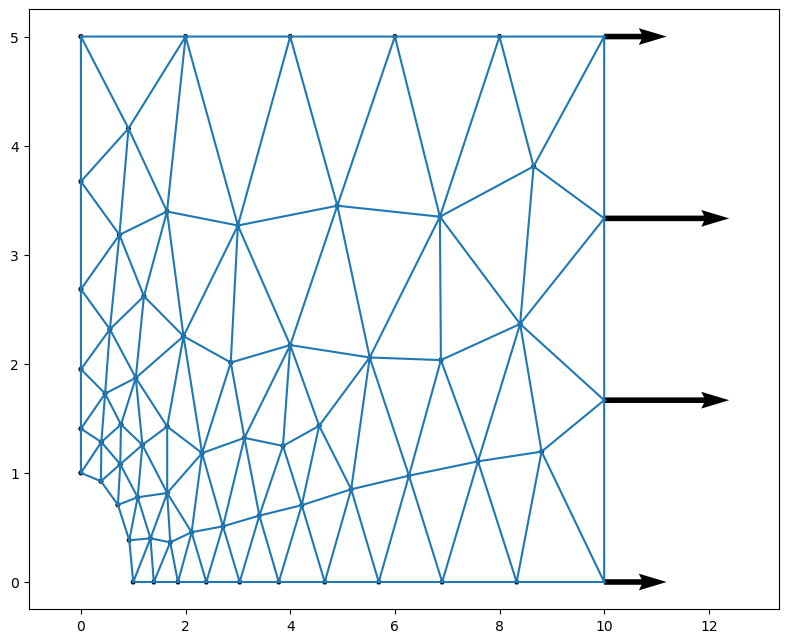

In [24]:
import matplotlib.pyplot as plt
from matplotlib import quiver

plt.style.use('default')
plt.rc('figure',figsize=(15,10))

fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.5, 0.6])
ax.triplot(MN[:,0],MN[:,1],MC-1, )
ax.quiver( MN[:,0], MN[:,1], Exy[:,0], Exy[:,1], linewidth=5, units='width', scale=10000)
ax.set_xlim([-1, Long+(Exy[:,0]/500).max()])

# Agregar Resulatados

In [25]:
# import mefmods as mef
mef = SourceFileLoader('mef','mefmods.py').load_module()

In [26]:
ETYPES = 2*np.ones(len(MC)).astype(int)

nu = 0.3

E = 210E9

MP = np.hstack(
        (
            np.ones((len(MC), 1)),
            np.ones((len(MC), 1))*nu,
            np.ones((len(MC), 1))*E
            )
        )

In [27]:
K = mef.ensamble(MC-1, MN, MP, 2, ETYPES, 'Cuarto-De-Chapa-2021')

In [28]:
s.sort()

In [29]:
#Desplazamientos[r] = 
Desplazamientos, FResultado = mef.resolvermef(r,s,K,Desplazamientos[s], Fuerzas[r], 'Chapa-Asimetrica-2021')

In [30]:
# import mefmods as mef
mef = SourceFileLoader('mef','mefmods.py').load_module()
sigma = mef.getstress2(MC, ETYPES, MP, MN, Desplazamientos)

In [31]:
SA = 0.5*(sigma[:,0]+sigma[:,1])
SB = np.sqrt(SA**2+ sigma[:,2]**2)
SIGMA_MAX = SA+SB
SIGMA_MIN = SA-SB

In [32]:
Rxy = np.hstack( (FResultado.reshape(NumeroNodos, 2) , np.zeros((NumeroNodos, 1))) )

In [33]:
Dxy = np.hstack( (Desplazamientos.reshape(NumeroNodos, 2) , np.zeros((NumeroNodos, 1))) )

In [34]:
SIGMA_AVE_MAX = np.zeros([NumeroNodos,1])

In [35]:
SIGMA_AVE_MIN = np.zeros([NumeroNodos,1])

In [36]:
for node in range(NumeroNodos):
    SIGMA_AVE_MAX[node] = SIGMA_MAX[ ETAGS[ (MC == node+1).any(axis=1) ] - ETAGS.min() ].mean()

In [37]:
for node in range(NumeroNodos):
    SIGMA_AVE_MIN[node] = SIGMA_MIN[ ETAGS[ (MC == node+1).any(axis=1) ] - ETAGS.min() ].mean()

# Guardo los resultados 

In [38]:
despview = gmsh.view.add('Desplazamientos')
Desp = gmsh.view.addModelData(despview,0,modelname,'NodeData',NodeInfo[0],Dxy)
gmsh.option.setNumber(f'View[{Desp}].VectorType', 5)

In [39]:
forview = gmsh.view.add('Fuerzas')
Fza = gmsh.view.addModelData(forview,0,modelname,'NodeData',NodeInfo[0], Rxy)
gmsh.option.setNumber(f'View[{Fza}].VectorType', 4)
gmsh.option.setNumber(f'View[{Fza}].GlyphLocation', 2)

In [40]:
tenmaxview = gmsh.view.add('Tension Maxima')
tenmax = gmsh.view.addModelData(tenmaxview,0,modelname,'ElementData',ETAGS, SIGMA_MAX.reshape(-1,1))

In [41]:
tenminview = gmsh.view.add('Tension Mínima')
tenmax = gmsh.view.addModelData(tenminview,0,modelname,'ElementData',ETAGS, SIGMA_MIN.reshape(-1,1))

In [42]:
tenxview = gmsh.view.add('Sigma_x')
tenx = gmsh.view.addModelData(tenxview,0,modelname,'ElementData',ETAGS, sigma[:,0].reshape(-1,1))

In [43]:
tenyview = gmsh.view.add('Sigma_y')
teny = gmsh.view.addModelData(tenyview,0,modelname,'ElementData',ETAGS, sigma[:,1].reshape(-1,1))

In [44]:
tencorte = gmsh.view.add('Tau_xy')
tenc = gmsh.view.addModelData(tencorte, 0,modelname,'ElementData',ETAGS, sigma[:,2].reshape(-1,1))

In [45]:
tenmaxave = gmsh.view.add('Sigma_max_ave')
tenmave = gmsh.view.addModelData(tenmaxave, 0,modelname,'NodeData',NodeInfo[0], SIGMA_AVE_MAX.reshape(-1,1))

In [46]:
tenminave = gmsh.view.add('Sigma_min_ave')
tenmiave = gmsh.view.addModelData(tenminave, 0,modelname,'NodeData',NodeInfo[0], SIGMA_AVE_MIN.reshape(-1,1))

In [47]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.8.4
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20210428
Build host    : gmsh.info
Build options : 64Bit ALGLIB ANN Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen Fltk Gmm Hxt Jpeg[fltk] Kbipack Lapack[petsc] LinuxJoystick MathEx Med Mesh Metis Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OptHom PETSc Parser Plugins Png[fltk] Post QuadTri Solver TetGen/BR Voro++ Zlib[fltk]
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.6.0
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


In [48]:
gmsh.finalize()